Historical  data 

In [388]:
import yfinance as yf
import numpy as np
import pandas as pd
import matplotlib as mpl

In [389]:
initial_data = yf.download('LTC-USD', start='2020-11-01', end='2022-11-01')

[*********************100%***********************]  1 of 1 completed


In [390]:
initial_data.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2020-11-01,55.590260,55.974216,54.259636,55.587624,55.587624,2045991010
2020-11-02,55.587322,56.710835,53.205944,53.817482,53.817482,3019889902
2020-11-03,53.817410,54.272400,51.648445,53.819622,53.819622,2580300879
2020-11-04,53.819469,55.007088,51.606560,54.499104,54.499104,3050534139
2020-11-05,54.501873,59.223793,54.501873,58.678497,58.678497,3250514599


In [391]:
initial_data['Adj Close'].head()

Date
2020-11-01    55.587624
2020-11-02    53.817482
2020-11-03    53.819622
2020-11-04    54.499104
2020-11-05    58.678497
Name: Adj Close, dtype: float64

In [392]:
data =  initial_data['Adj Close']
data.info()

<class 'pandas.core.series.Series'>
DatetimeIndex: 730 entries, 2020-11-01 to 2022-10-31
Series name: Adj Close
Non-Null Count  Dtype  
--------------  -----  
730 non-null    float64
dtypes: float64(1)
memory usage: 11.4 KB


In [393]:
data.head()

Date
2020-11-01    55.587624
2020-11-02    53.817482
2020-11-03    53.819622
2020-11-04    54.499104
2020-11-05    58.678497
Name: Adj Close, dtype: float64

In [394]:
data.tail()

Date
2022-10-27    54.807610
2022-10-28    55.003899
2022-10-29    56.496178
2022-10-30    55.389553
2022-10-31    55.084435
Name: Adj Close, dtype: float64

array([<AxesSubplot:xlabel='Date'>], dtype=object)

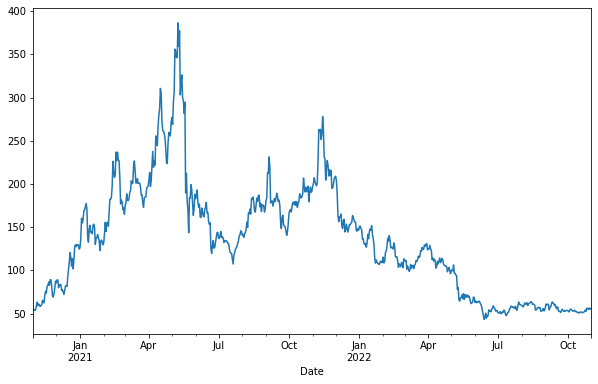

In [395]:
data.plot(figsize=(10, 6), subplots=True)

Three months period 

In [396]:
df = data[-92:-1]
df.head()

Date
2022-08-01    59.535446
2022-08-02    58.243855
2022-08-03    57.805191
2022-08-04    59.848576
2022-08-05    62.401272
Name: Adj Close, dtype: float64

In [397]:
log_return = np.log(df / df.shift(1))
log_return

Date
2022-08-01         NaN
2022-08-02   -0.021933
2022-08-03   -0.007560
2022-08-04    0.034739
2022-08-05    0.041768
                ...   
2022-10-26    0.006521
2022-10-27   -0.028493
2022-10-28    0.003575
2022-10-29    0.026769
2022-10-30   -0.019782
Name: Adj Close, Length: 91, dtype: float64

In [398]:
vol = np.sqrt(365) * log_return.std()
print('The annualised volatility is', round(vol*100,2), '%')

The annualised volatility is 62.84 %


Binomial Tree (CRR Tree)

In [399]:
import numpy as np
import os

Data Input

In [400]:
df[-1]

55.38955307006836

In [401]:
S0 = df[-1]              # spot stock price
K = 52.0                 # strike
T = 0.25                 # maturity 
r = 0.038                 # risk free rate 
sig = vol               # diffusion coefficient or volatility
N = 2                   # number of periods or number of time steps  
payoff = "put"          # payoff 

In [402]:
sig

0.6283737892604491

Create the binomial price tree

In [403]:
dT = float(T) / N                             # Delta t
u = np.exp(sig * np.sqrt(dT))                 # up factor
d = 1.0 / u                                   # down factor 

In [404]:
S = np.zeros((N + 1, N + 1))
S[0, 0] = S0
z = 1
for t in range(1, N + 1):
    for i in range(z):
        S[i, t] = S[i, t-1] * u
        S[i+1, t] = S[i, t-1] * d
    z += 1

In [405]:
S

array([[55.38955307, 69.16913153, 86.37673517],
       [ 0.        , 44.35508328, 55.38955307],
       [ 0.        ,  0.        , 35.51885335]])

In [406]:
a = np.exp(r * dT)    # risk free compound return
p = (a - d)/ (u - d)  # risk neutral up probability
q = 1.0 - p           # risk neutral down probability
p

0.4553145020077646

 Find option value at each final node

In [407]:
S_T = S[:,-1]
V = np.zeros((N + 1, N + 1))
if payoff =="put":
    V[:,-1] = np.maximum(K-S_T, 0.0)
V


array([[ 0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        , 16.48114665]])

Find option value at earlier nodes


European Option

In [408]:
# for European Option
for j in range(N-1, -1, -1):
    for i in range(j+1):
        V[i,j] = np.exp(-r*dT) * (p * V[i,j + 1] + q * V[i + 1,j + 1])
V

array([[ 4.8434325 ,  0.        ,  0.        ],
       [ 0.        ,  8.93450174,  0.        ],
       [ 0.        ,  0.        , 16.48114665]])

In [409]:
print('European ' + payoff, str( V[0,0]))

European put 4.8434324966892985


MONTE CARLO SIMULATION

In [410]:
def mcs_simulation_np(p):
    M = p
    I = p
    dt = T / M 
    S = np.zeros((M + 1, I))
    S[0] = S0 
    rn = np.random.standard_normal(S.shape) 
    for t in range(1, M + 1): 
        S[t] = S[t-1] * np.exp((r - sig ** 2 / 2) * dt + sig * np.sqrt(dt) * rn[t]) 
    return S

In [411]:
S = mcs_simulation_np(10000)

In [412]:
S = np.transpose(S)
S

array([[55.38955307, 55.56602504, 55.721359  , ..., 54.64627248,
        54.78305869, 54.80594623],
       [55.38955307, 55.24840048, 55.18074137, ..., 56.67330137,
        56.69500853, 56.67878868],
       [55.38955307, 55.56473032, 55.61040475, ..., 84.43960453,
        84.59436459, 84.49254874],
       ...,
       [55.38955307, 55.32697122, 55.11490205, ..., 55.22208152,
        55.38633553, 55.43794854],
       [55.38955307, 55.34038158, 55.69237995, ..., 51.14445213,
        51.07563172, 51.16188033],
       [55.38955307, 55.36619004, 55.22600735, ..., 42.11673167,
        42.33050267, 42.23994538]])

Text(0.5, 1.0, 'Frequency distribution of the simulated end-of-preiod values')

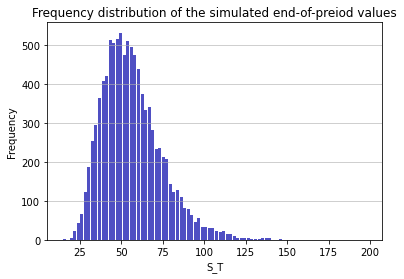

In [413]:
import matplotlib.pyplot as plt
n, bins, patches = plt.hist(x=S[:,-1], bins='auto', color='#0504aa',alpha=0.7, rwidth=0.85)

plt.grid(axis='y', alpha=0.75)
plt.xlabel('S_T')
plt.ylabel('Frequency')
plt.title('Frequency distribution of the simulated end-of-preiod values')

In [414]:
p = np.mean(np.maximum(K - S[:,-1],0))
print('European put', str(p))

European put 4.826356586128879


GREEKS

OPTION VALUE

In [415]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.stats as si

In [416]:
def euro_option_bsm(S, K, T, r, q, vol, payoff):
    
    #S: spot price
    #K: strike price
    #T: time to maturity
    #r: risk free rate
    #q: continuous dividend yield
    #vol: volatility of underlying asset
    #payoff: call or put
    
    d1 = (np.log(S / K) + (r - q + 0.5 * vol ** 2) * T) / (vol * np.sqrt(T))
    d2 = (np.log(S / K) + (r - q - 0.5 * vol ** 2) * T) / (vol * np.sqrt(T))
    if payoff == "put":
        option_value =  - S * np.exp(-q * T) * si.norm.cdf(-d1, 0.0, 1.0) + K * np.exp(-r * T) * si.norm.cdf(-d2, 0.0, 1.0)
    
    return option_value

In [417]:
euro_option_bsm(S0,K, T,r, q, sig, 'put')

7.942834647001558

In [418]:
S = np.linspace(30,90,11)
Put = np.zeros((len(S),1))
for i in range(len(S)):
    Put [i] = euro_option_bsm(S[i],K, T,r, q, sig, 'put' )

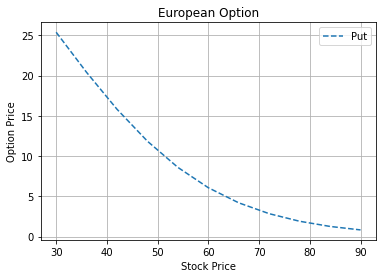

In [419]:
fig = plt.figure()
plt.plot(S, Put, '--')
plt.grid()
plt.xlabel('Stock Price')
plt.ylabel('Option Price')
plt.title('European Option')
plt.legend(['Put'])


DELTA

Delta, denotes the change rate of the theoretical option value in relation to changes in the price of the underlying asset. 

In [420]:
def delta(S, K, T, r, q, vol, payoff):
    
    d1 = (np.log(S / K) + (r - q + 0.5 * vol ** 2) * T) / (vol * np.sqrt(T))
    if payoff == "put":
        delta =  - np.exp(-q * T) * si.norm.cdf(-d1, 0.0, 1.0)
    
    return delta


In [421]:
delta(S0,K, T,r, q, sig, 'put')

-0.4520402598269211

In [422]:
S = np.linspace(30,90,21)
Delta_Put = np.zeros((len(S),1))
for i in range(len(S)):
    Delta_Put [i] = delta(S[i], K, T,r, q, sig, 'put')

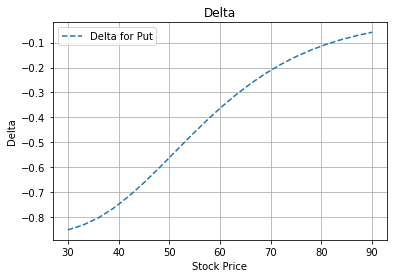

In [423]:
fig = plt.figure()
plt.plot(S, Delta_Put, '--')
plt.grid()
plt.xlabel('Stock Price')
plt.ylabel('Delta')
plt.title('Delta')
plt.legend(['Delta for Put'])

In [424]:
d = delta(S0,K, T,r, q, sig, 'put')
print('The value of Delta is', d.round(4),'.','If the stock price increase 1 dollar, then the value of the option will decrease $', d.round(4), '.')

The value of Delta is -0.452 . If the stock price increase 1 dollar, then the value of the option will decrease $ -0.452 .


GAMMA

Gamma, denotes the rate at which the delta changes in relation to changes in the underlying price.

In [425]:
def gamma(S, K, T, r, q, vol, payoff):
    
    d1 = (np.log(S / K) + (r - q + 0.5 * vol ** 2) * T) / (vol * np.sqrt(T))
    gamma = np.exp(- q * T) * si.norm.pdf(d1, 0.0, 1.0) / (vol * S * np.sqrt(T))
    
    return gamma

In [426]:
gamma(S0,K, T,r, q, sig, 'put')

0.019985459373076057

In [427]:
S = np.linspace(30,90,11)
Gamma = np.zeros((len(S),1))
for i in range(len(S)):
    Gamma [i] = gamma(S[i],K, T,r, q, sig, 'put' )

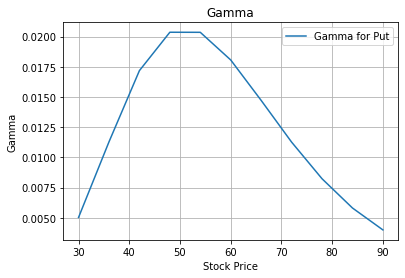

In [428]:
fig = plt.figure()
plt.plot(S, Gamma, '-')
plt.grid()
plt.xlabel('Stock Price')
plt.ylabel('Gamma')
plt.title('Gamma')
plt.legend(['Gamma for Put'])

SPEED

Speed expresses  the rate of change in Gamma changes in response to changes in the underlying price.

In [429]:
def speed(S, K, T, r, q, vol, payoff):
    
    d1 = (np.log(S / K) + (r - q + 0.5 * vol ** 2) * T) / (vol * np.sqrt(T))
    speed = - np.exp(-q * T) * si.norm.pdf(d1, 0.0, 1.0) / ((vol **2) * (S**2) * np.sqrt(T)) * (d1 + vol * np.sqrt(T))
    
    return speed

In [430]:
speed(S0,K, T,r, q, sig, 'put')

-0.00015451594455450062

In [431]:
S = np.linspace(30,90,11)
Speed = np.zeros((len(S),1))
for i in range(len(S)):
    Speed [i] = speed(S[i],K, T,r, q, sig, 'put' ) 

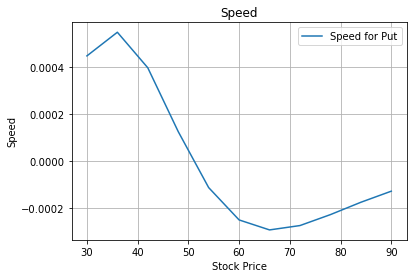

In [432]:
fig = plt.figure()
plt.plot(S, Speed, '-')
plt.grid()
plt.xlabel('Stock Price')
plt.ylabel('Speed')
plt.title('Speed')
plt.legend(['Speed for Put'])

THETA

Theta captures the sensitivity of the derivative's value to the passage of time.

In [433]:
def theta(S, K, T, r, q, vol, payoff):
    
    d1 = (np.log(S / K) + (r - q + 0.5 * vol ** 2) * T) / (vol * np.sqrt(T))
    d2 = (np.log(S / K) + (r - q - 0.5 * vol ** 2) * T) / (vol * np.sqrt(T))
    if payoff == "put":
        theta = vol * S * np.exp(-q * T) * si.norm.pdf(-d1, 0.0, 1.0) / (2 * np.sqrt(T)) - q * S * np.exp(-q * T) * si.norm.cdf(-d1, 0.0, 1.0) + r * K * np.exp(-r * T) * si.norm.cdf(-d2, 0.0, 1.0)
    
    return theta

In [434]:
theta(S0, K, T,r, q, sig, 'put')

-0.2794079104168741

In [435]:
T = np.linspace(0.25,1,10)
Theta_Put = np.zeros((len(T),1))
for i in range(len(T)):
    Theta_Put [i] = theta(S0,K, T[i], r, q, sig, 'put')

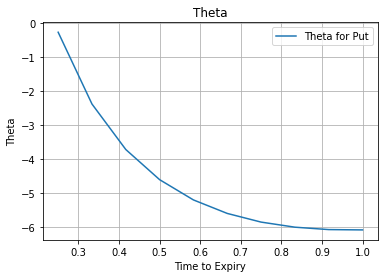

In [436]:
fig = plt.figure()
plt.plot(T, Theta_Put, '-')
plt.grid()
plt.xlabel('Time to Expiry')
plt.ylabel('Theta')
plt.title('Theta')
plt.legend(['Theta for Put'])

VEGA

Vega determines volatility sensitivity. Vega is the option value's derivative with regard to the volatility of the underlying asset.

In [475]:
def vega(S, K, T, r, q, vol, payoff):
    
    d1 = (np.log(S / K) + (r - q + 0.5 * vol ** 2) * T) / (vol * np.sqrt(T))
    vega = S * np.sqrt(T) * np.exp(-q * T) * si.norm.pdf(d1, 0.0, 1.0)
    
    return vega

In [477]:
T = 0.25 # time to maturity is 3 months
vega(S0,K,T,r,q,sig,'put')

9.632254016828933

In [481]:
vol = np.linspace(0.1,1,13)
Vega = np.zeros((len(vol),1))
for i in range(len(vol)):
    Vega [i] = vega(S0, K, T, r, q, vol[i], 'put')

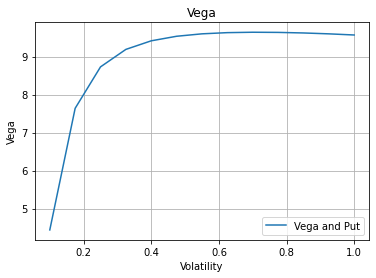

In [482]:
fig = plt.figure()
plt.plot(vol, Vega, '-')
plt.grid()
plt.xlabel('Volatility')
plt.ylabel('Vega')
plt.title('Vega')
plt.legend(['Vega and Put'])


In [483]:
v = vega(S0, K, T, r, q, sig, 'put')
print('The value of Vega is', v.round(4),'.','If the volatility increases 1%, then the value of the option will increase $', v.round(4)*0.01, '.')

The value of Vega is 9.6323 . If the volatility increases 1%, then the value of the option will increase $ 0.096323 .
